# Logistic regression To predict heart disease

## Import libraries and dataset

In [267]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import time
from scipy.stats import loguniform, uniform

In [268]:
df = pd.read_csv("framingham.csv")
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Variables Description

| **Category**       | **Variable Name**      | **Description**                                                                 | **Type**      |
|---------------------|------------------------|---------------------------------------------------------------------------------|---------------|
| **Demographic**     | Sex                    | Male or Female                                                                  | Nominal       |
|                     | Age                    | Age of the patient (truncated to whole numbers, treated as continuous)          | Continuous    |
|                     | Education              | Trình độ học vấn                                                                | Ordinal       |
| **Behavioral**      | Current Smoker         | Whether the patient is a current smoker                                         | Nominal       |
|                     | Cigs Per Day           | Average number of cigarettes smoked per day (treated as continuous)             | Continuous    |
| **Medical (History)**| BP Meds               | Whether the patient was on blood pressure medication                            | Nominal       |
|                     | Prevalent Stroke       | Whether the patient had previously had a stroke                                 | Nominal       |
|                     | Prevalent Hyp          | Whether the patient was hypertensive                                            | Nominal       |
|                     | Diabetes               | Whether the patient had diabetes                                                | Nominal       |
| **Medical (Current)**| Tot Chol              | Total cholesterol level                                                         | Continuous    |
|                     | Sys BP                 | Systolic blood pressure                                                         | Continuous    |
|                     | Dia BP                 | Diastolic blood pressure                                                        | Continuous    |
|                     | BMI                    | Body Mass Index                                                                 | Continuous    |
|                     | Heart Rate             | Heart rate (treated as continuous due to large possible values)                 | Continuous    |
|                     | Glucose                | Glucose level                                                                   | Continuous    |
| **Target Variable** | 10 Year CHD Risk       | 10-year risk of coronary heart disease (1 = "Yes", 0 = "No")                   | Binary        |

## Simple EDA

In [269]:
df.shape

(4238, 16)

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [271]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


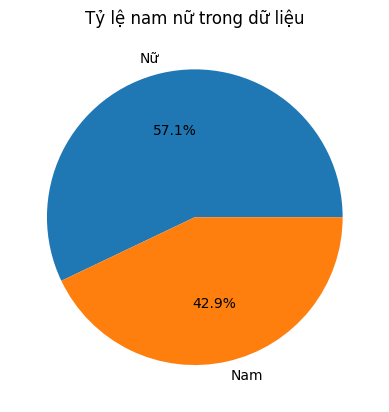

In [272]:
import matplotlib.pyplot as plt
plt.pie(df["male"].value_counts(), labels=["Nữ", "Nam"], autopct='%1.1f%%')
plt.rcParams['text.color'] = 'black'
plt.title("Tỷ lệ nam nữ trong dữ liệu")
plt.show()

-> Cân bằng về mặt giới tính

In [273]:
# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 glucose            388
education          105
BPMeds              53
totChol             50
cigsPerDay          29
BMI                 19
heartRate            1
male                 0
prevalentHyp         0
prevalentStroke      0
age                  0
currentSmoker        0
diaBP                0
sysBP                0
diabetes             0
TenYearCHD           0
dtype: int64


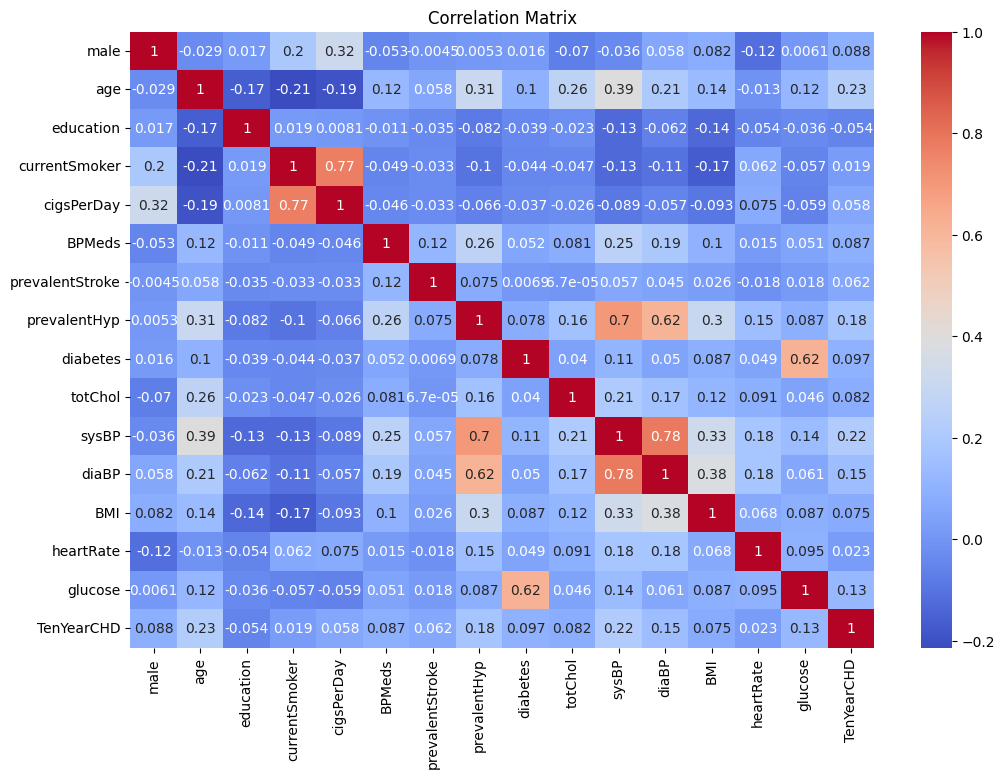

In [274]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [275]:
df.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

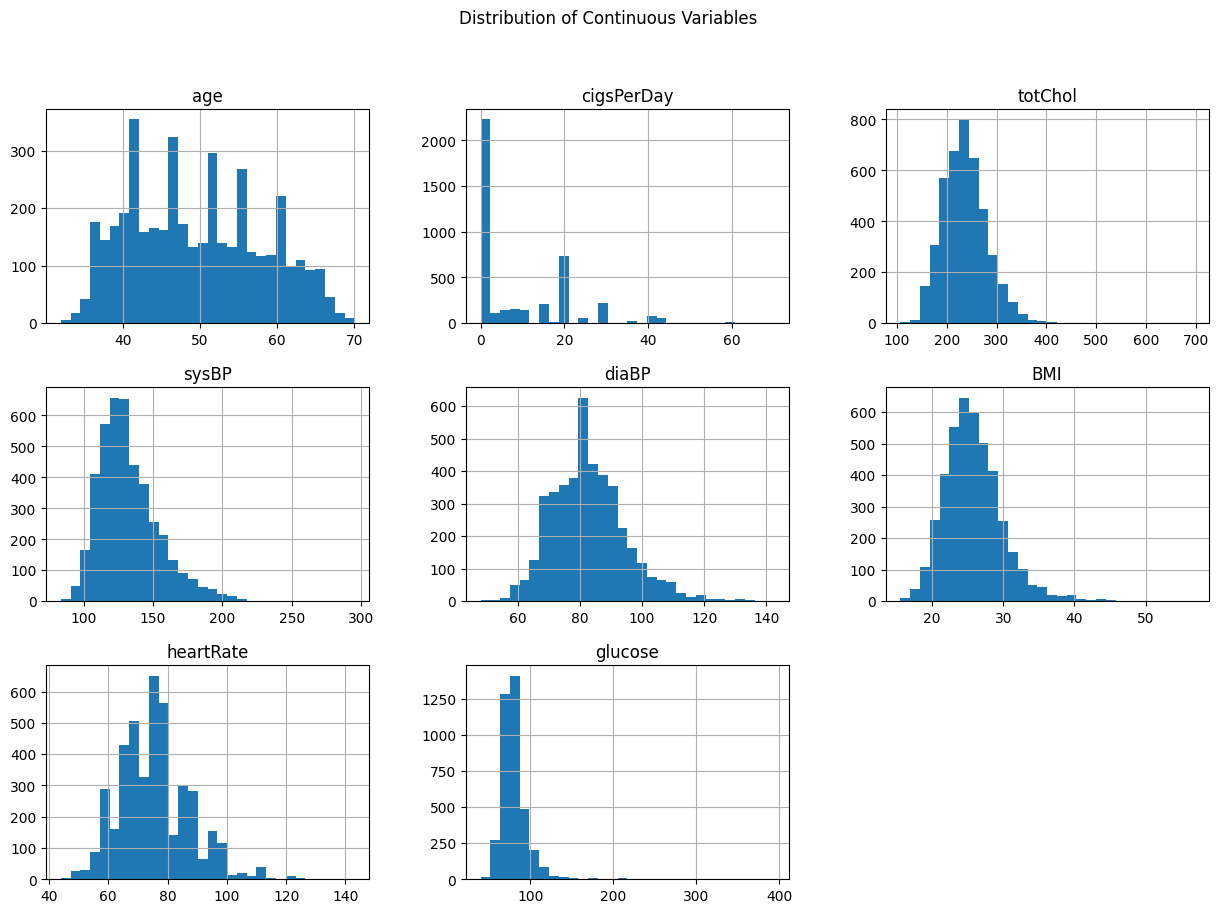

In [276]:
# Distribution of continuous variables
continuous_vars = ["age","cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]

df[continuous_vars].hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.suptitle("Distribution of Continuous Variables")
plt.show()

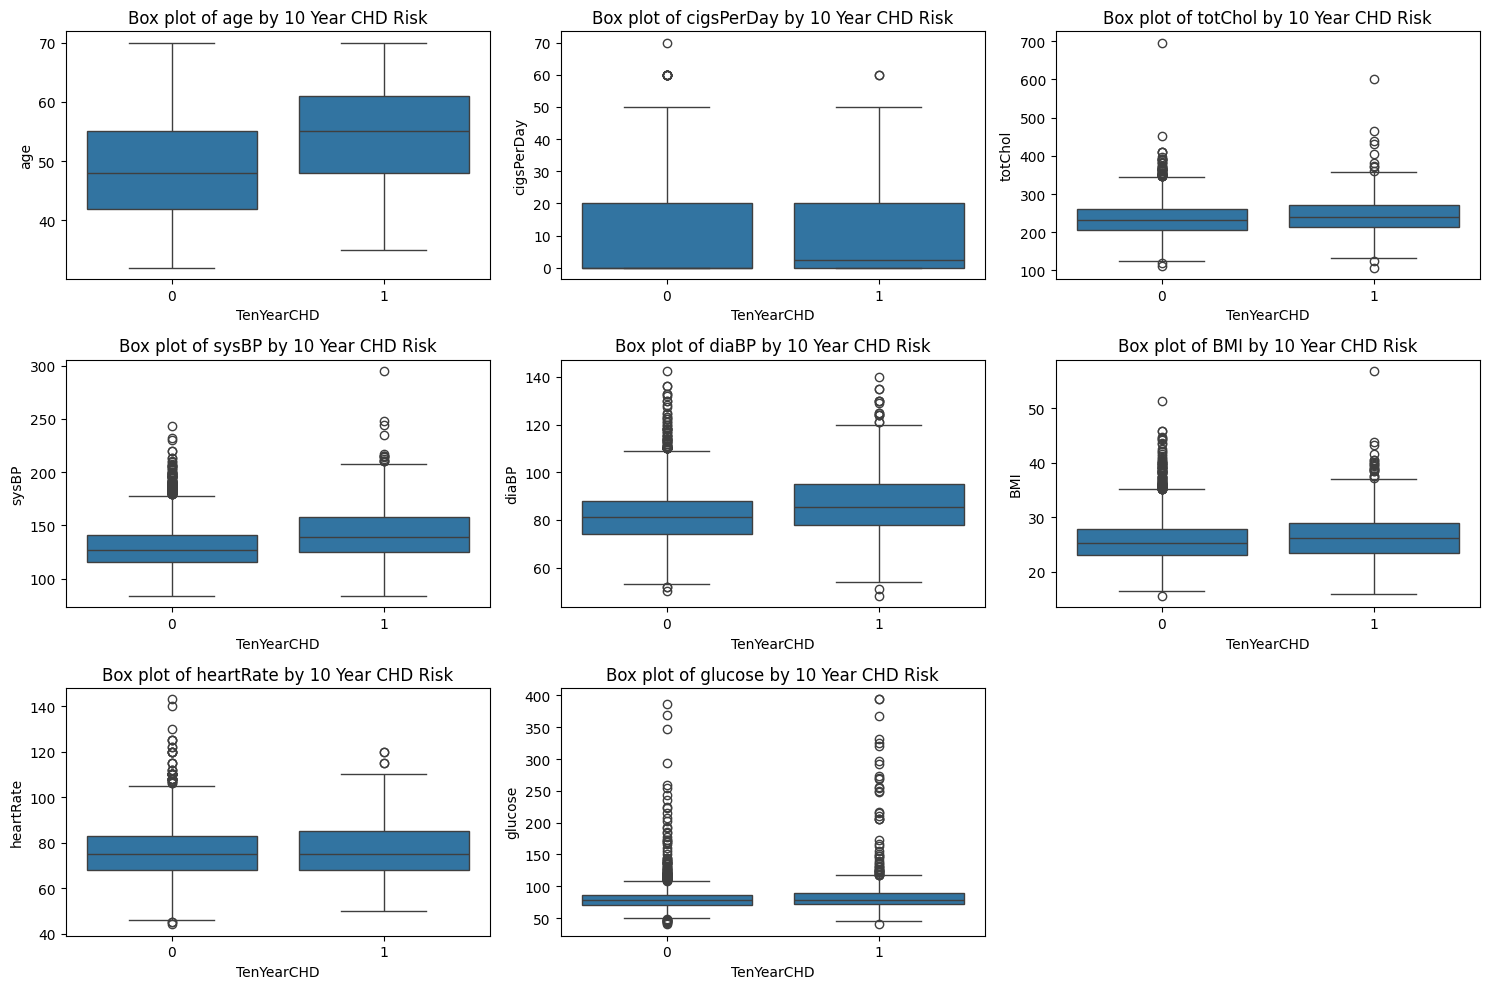

In [277]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()  

for i, var in enumerate(continuous_vars):
    if i < 9:  
        sns.boxplot(x='TenYearCHD', y=var, data=df, ax=axes[i])
        axes[i].set_title(f'Box plot of {var} by 10 Year CHD Risk')
        axes[i].set_xlabel('TenYearCHD')
        axes[i].set_ylabel(var)

for j in range(len(continuous_vars), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Check if imbalance

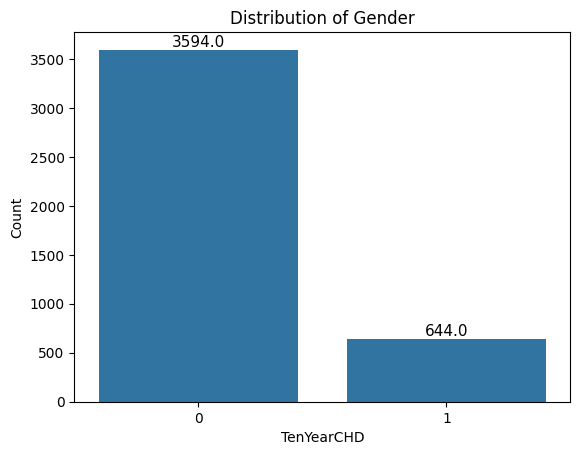

In [278]:
# Vẽ biểu đồ đếm bằng seaborn

sns.countplot(x='TenYearCHD', data=df)
plt.title("Distribution of Gender")
plt.xlabel("TenYearCHD")
plt.ylabel("Count")

# Adding number labels above each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                       textcoords='offset points')

plt.show()


Xem xét cột education có thực sự ảnh hưởng đến người bị mắc bệnh  không (Ở đoạn này tôi chấp nhận data leakage vì ở đây bị leak không nghiêm trọng)

In [279]:
# Lấy ra tỷ lệ giá trị số 1 (tỷ lệ người mắc bệnh của từng nhóm education)
df.groupby("education")["TenYearCHD"].mean()

education
1.0    0.187791
2.0    0.117318
3.0    0.128093
4.0    0.147992
Name: TenYearCHD, dtype: float64

--> Mặc dù trình độ học vấn tăng nhưng tỷ lệ người mắc bệnh trong từng nhóm tương ứng thì lại không có mối liên quan cho lắm (không tăng hoặc không giảm). Hơn nữa thì xem biểu đồ heatmap ta cũng thấy rằng education chả liên quan cho lắm đến target (-0,054). Mặt khác theo lập luận thông thường của chúng ta thì trình độ học tập là bao nhiêu thì có vẻ cũng chẳng liên quan đến bệnh tim hay không. Vậy nên chúng ta loại bỏ cột này

In [280]:
df.drop(columns='education', axis=1, inplace=True)

## Simple Data Cleaning

In [281]:
# Chỉ lấy những giá trị age > 0
df["age"] = df[df["age"]>0]["age"]

In [282]:
# Chí lấy những giá trị cigsPerDay > 0
df["cigsPerDay"] = df[df["cigsPerDay"]>0]["cigsPerDay"]

In [283]:
# Loại trùng
df.drop_duplicates(inplace=True)

In [284]:
# Loại bỏ các dòng chứa NULL ở cột target
df = df.dropna(subset=["TenYearCHD"])

In [285]:
# Cột nào thiếu nhiều xóa luôn
many_null = [col for col in df.columns if df[col].isnull().sum()/len(df) > 0.7]
if many_null:
    df.drop(many_null, axis=1, inplace=True)
    print(f"Đã xóa các cột {many_null}")
else:
    print("Không có cột nào chứa nhiều giá trị null hết !")

Không có cột nào chứa nhiều giá trị null hết !


## Split data to X and y

In [286]:
# Tách features (X) và target (y) từ dữ liệu gốc
X_original = df.drop('TenYearCHD', axis=1)
y_original = df['TenYearCHD']

# Chia dữ liệu gốc thành train và test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42, stratify=y_original
)

# Tạo bản sao để tránh thay đổi dữ liệu gốc đã chia
X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

## Feature Engineering

Xử lý các giá trị NULL

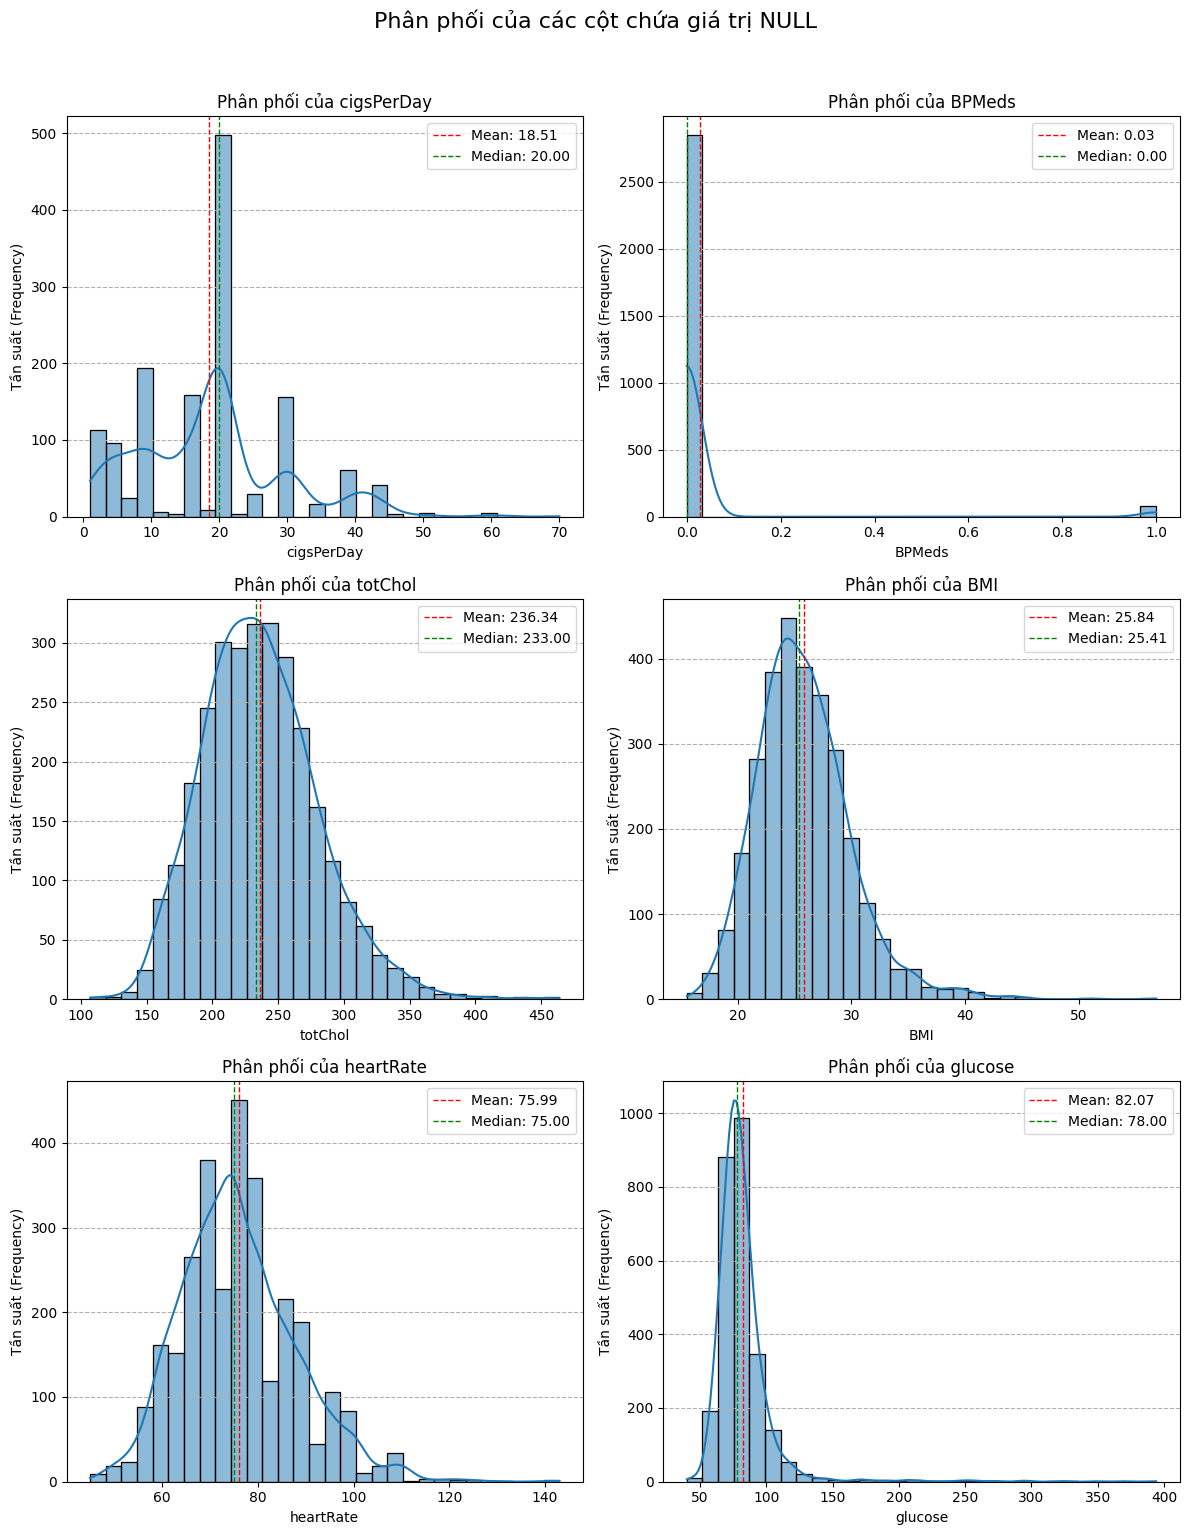

In [287]:
# Các cột có chứa null mà bạn muốn xem phân phối
cols_to_plot_dist = ['cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']

# Lọc ra các cột thực sự tồn tại trong X_train
cols_to_plot_dist = [col for col in cols_to_plot_dist if col in X_train.columns]

# Tính số hàng và cột cho lưới subplot
n_cols = len(cols_to_plot_dist)
n_rows = (n_cols + 1) // 2 # Sắp xếp thành 2 cột

plt.figure(figsize=(12, 5 * n_rows))
plt.suptitle('Phân phối của các cột chứa giá trị NULL', fontsize=16, y=1.02)

for i, col in enumerate(cols_to_plot_dist):
    plt.subplot(n_rows, 2, i + 1)

    # Lấy dữ liệu không phải null của cột hiện tại từ X_train
    data_to_plot = X_train[col].dropna()

    # Vẽ histogram bằng seaborn (có thể thêm kde=True để vẽ đường ước lượng mật độ)
    sns.histplot(data_to_plot, kde=True, bins=30) # bins=30 là số lượng cột trong histogram

    # Tính toán và hiển thị mean, median (nếu là cột số)
    if pd.api.types.is_numeric_dtype(data_to_plot):
        mean_val = data_to_plot.mean()
        median_val = data_to_plot.median()
        plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
        plt.legend()

    plt.title(f'Phân phối của {col}')
    plt.xlabel(col)
    plt.ylabel('Tần suất (Frequency)')
    plt.grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 1]) # Điều chỉnh layout để không bị chồng chéo
plt.show()

Như chúng ta thấy ở dưới rằng cột cigsPerDay có số lượng 0 chiếm ưu thế, vậy nên ta thay giá tị NULL tại đó là 0 (mode)

In [288]:
X_train ["cigsPerDay"] = X_train["cigsPerDay"].fillna(X_train["cigsPerDay"].mode()[0])
X_test["cigsPerDay"] = X_test["cigsPerDay"].fillna(X_train["cigsPerDay"].mode()[0])

Tương tự, do cột BPMeds 0 chiếm ưu thế nên ta thay các giá trị NULL = 0

In [289]:
X_train["BPMeds"] = X_train["BPMeds"].fillna(X_train["BPMeds"].mode()[0])
X_test["BPMeds"] = X_test["BPMeds"].fillna(X_train["BPMeds"].mode()[0])

Cột totChol, BMI, heartrate phân phối gần giống phân phối chuẩn mặc dù hơi lệch phải. Tuy vậy ta vẫn có thể thay bằng mean (nhìn hình)

In [290]:
X_train["heartRate"] = X_train["heartRate"].fillna(X_train["heartRate"].mean())
X_test["heartRate"] = X_test["heartRate"].fillna(X_train["heartRate"].mean())

In [291]:
X_train["totChol"] = X_train["totChol"].fillna(X_train["totChol"].mean())
X_test["totChol"] = X_test["totChol"].fillna(X_train["totChol"].mean())

In [292]:
X_train["BMI"] = X_train["BMI"].fillna(X_train["BMI"].mean())
X_test["BMI"] = X_test["BMI"].fillna(X_train["BMI"].mean())

Do cột glucose lệch phải nhiều nên ta thay bằng median

In [293]:
X_train["glucose"] = X_train["glucose"].fillna(X_train["glucose"].median())
X_test["glucose"] = X_test["glucose"].fillna(X_train["glucose"].median())

In [294]:

print("Number of null values in y:", y_original.isnull().sum())


Number of null values in y: 0


#### Bonus kiến thức
Trong bài này, ta đã bỏ cột "education" vì ta có thể lập luận được rằng cột đó có vẻ như không có ích cho lắm.  
Tuy vậy, với nhiều TH dữ liệu dạng ordinal như vậy, nếu nó thực sự có ích cho target. Thì ở bước này, ta cần OneHotEncoding nó  
Ta chỉ thực sự không cần OneHotEncoding khi mà dữ liệu tuy giống dạng ordinal nhưng vai trò của chúng là như nhau (tức ở TH này: education 1,2,3,4 là như nhau không ảnh hưởng đến target nếu bậc khác nhau).

#### Bàn về các giá trị ngoại lệ

Hãy phân tích kỹ hơn:

1.  **Bản chất của "Ngoại lệ" trong Y tế:**
    *   Trong nhiều bộ dữ liệu khác, ngoại lệ có thể là lỗi nhập liệu, lỗi đo lường. Việc loại bỏ chúng là hợp lý.
    *   Tuy nhiên, trong dữ liệu y tế như Framingham, các giá trị "ngoại lệ" (ví dụ: ``glucose`` rất cao, ``sysBP`` rất cao, ``totChol`` rất cao) thường **không phải là lỗi**, mà chúng **đại diện cho những cá nhân có tình trạng sức khỏe cực đoan**, và những người này **thường có nguy cơ mắc bệnh tim cao nhất**. Đây chính là những trường hợp mà mô hình cần dự đoán chính xác!

2.  **Tác động tiêu cực của việc xử lý ngoại lệ không phù hợp:**
    *   **Loại bỏ (Removal):** Nếu bạn loại bỏ hoàn toàn những người có chỉ số rất cao, mô hình sẽ không được "học" về mối liên hệ giữa các chỉ số cực đoan này và nguy cơ bệnh tim. Khi gặp một trường hợp tương tự trong thực tế, mô hình có thể dự đoán sai (đánh giá thấp nguy cơ).
    *   **Giới hạn giá trị (Capping/Winsorization):** Việc "ép" các giá trị rất cao xuống một ngưỡng nhất định (ví dụ: percentile 99) có thể làm giảm "tín hiệu" về mức độ nguy hiểm của các giá trị đó. Mô hình có thể không phân biệt được giữa một người có chỉ số "rất cao" và một người có chỉ số "cực kỳ cao".

3.  **Vậy tại sao chúng ta lại bàn về xử lý ngoại lệ?**
    *   Như đã thảo luận ở câu trả lời trước, lý do chính là vì các mô hình tuyến tính như **Logistic Regression** và các kỹ thuật tiền xử lý như **``StandardScaler``** (dựa trên trung bình và độ lệch chuẩn) **rất nhạy cảm với các giá trị ngoại lệ về mặt *thống kê***. Các ngoại lệ này có thể:
        *   Làm sai lệch các tham số thống kê (mean, std dev) dùng để chuẩn hóa, ảnh hưởng đến việc scale của *tất cả* các điểm dữ liệu khác.
        *   Có "đòn bẩy" (leverage) không cân xứng lên việc xác định đường hồi quy (decision boundary), có thể làm lệch kết quả dự đoán cho cả các điểm không phải ngoại lệ.

**Giải pháp cân bằng:**

Mục tiêu không phải là loại bỏ thông tin quý giá về các trường hợp nguy cơ cao, mà là làm cho dữ liệu phù hợp hơn với giả định của mô hình Logistic Regression mà không làm mất đi tín hiệu quan trọng. Các cách tiếp cận tốt hơn thay vì loại bỏ hoàn toàn:

1.  **Biến đổi dữ liệu (Data Transformation):**
    *   Đối với các biến lệch phải mạnh như ``glucose``, ``sysBP``, ``totChol``, ``cigsPerDay``, ``BMI``, áp dụng phép biến đổi log (log transform) hoặc các phép biến đổi căn bậc hai (square root), Box-Cox có thể giúp:
        *   Giảm độ lệch của phân phối, làm cho nó gần với phân phối chuẩn hơn.
        *   "Kéo" các giá trị ngoại lệ lại gần hơn với phần lớn dữ liệu *mà không loại bỏ chúng*.
        *   Sau khi biến đổi, việc chuẩn hóa bằng ``StandardScaler`` sẽ ít bị ảnh hưởng bởi các giá trị cực đoan ban đầu hơn.
    *   *Đây thường là phương pháp được ưu tiên hàng đầu trong trường hợp này.*

2.  **Sử dụng Robust Scaler:** Như đã đề cập, ``RobustScaler`` sử dụng trung vị (median) và khoảng tứ phân vị (Interquartile Range - IQR), vốn ít bị ảnh hưởng bởi ngoại lệ. Bạn có thể chuẩn hóa dữ liệu bằng phương pháp này mà không cần xử lý ngoại lệ trước đó. Các giá trị ngoại lệ vẫn giữ nguyên vị trí tương đối của chúng (vẫn là các điểm xa) nhưng không làm sai lệch quá trình scale của các điểm khác.

3.  **Winsorization (Capping) một cách thận trọng:** Nếu vẫn muốn giới hạn giá trị, hãy chọn ngưỡng rất cao (ví dụ: percentile 99.5 hoặc 99.9) thay vì các ngưỡng thấp hơn, để chỉ ảnh hưởng đến các giá trị *cực kỳ* cực đoan.

4.  **Xem xét mô hình khác:** Các mô hình dựa trên cây quyết định (Decision Trees, Random Forest, Gradient Boosting) thường ít nhạy cảm với giá trị ngoại lệ và thang đo của dữ liệu hơn so với Logistic Regression. Nếu Logistic Regression gặp khó khăn với các ngoại lệ này, bạn có thể thử nghiệm các mô hình khác.

**Kết luận:**

Bạn hoàn toàn đúng khi lo ngại về việc xử lý ngoại lệ. **Không nên loại bỏ các giá trị ngoại lệ hợp lệ** trong dữ liệu y tế này. Thay vào đó, hãy tập trung vào các kỹ thuật như **biến đổi dữ liệu (log transform)** hoặc sử dụng **``RobustScaler``** để giảm thiểu tác động tiêu cực của ngoại lệ lên quá trình chuẩn hóa và mô hình Logistic Regression, trong khi vẫn giữ lại được thông tin quan trọng về các trường hợp có nguy cơ cao. Luôn kiểm tra hiệu suất mô hình trên tập kiểm tra (test set) sau khi áp dụng các kỹ thuật khác nhau để xem phương pháp nào mang lại kết quả dự đoán tốt nhất.

Ta xử lý bằng log transform những cột: 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose', 'heartRate'

In [295]:
cols_to_log_transform = ['cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose', 'heartRate']

for col in cols_to_log_transform:
    if col in X_train.columns:
        # Tạo cột mới hoặc thay thế cột cũ trên cả train và test
        X_train[col + '_log'] = np.log1p(X_train[col])
        X_test[col + '_log'] = np.log1p(X_test[col])
        print(f"Áp dụng log1p cho cột '{col}' trên train và test.")

Áp dụng log1p cho cột 'cigsPerDay' trên train và test.
Áp dụng log1p cho cột 'totChol' trên train và test.
Áp dụng log1p cho cột 'sysBP' trên train và test.
Áp dụng log1p cho cột 'diaBP' trên train và test.
Áp dụng log1p cho cột 'BMI' trên train và test.
Áp dụng log1p cho cột 'glucose' trên train và test.
Áp dụng log1p cho cột 'heartRate' trên train và test.


Xem phân phối sau khi biến đổi log

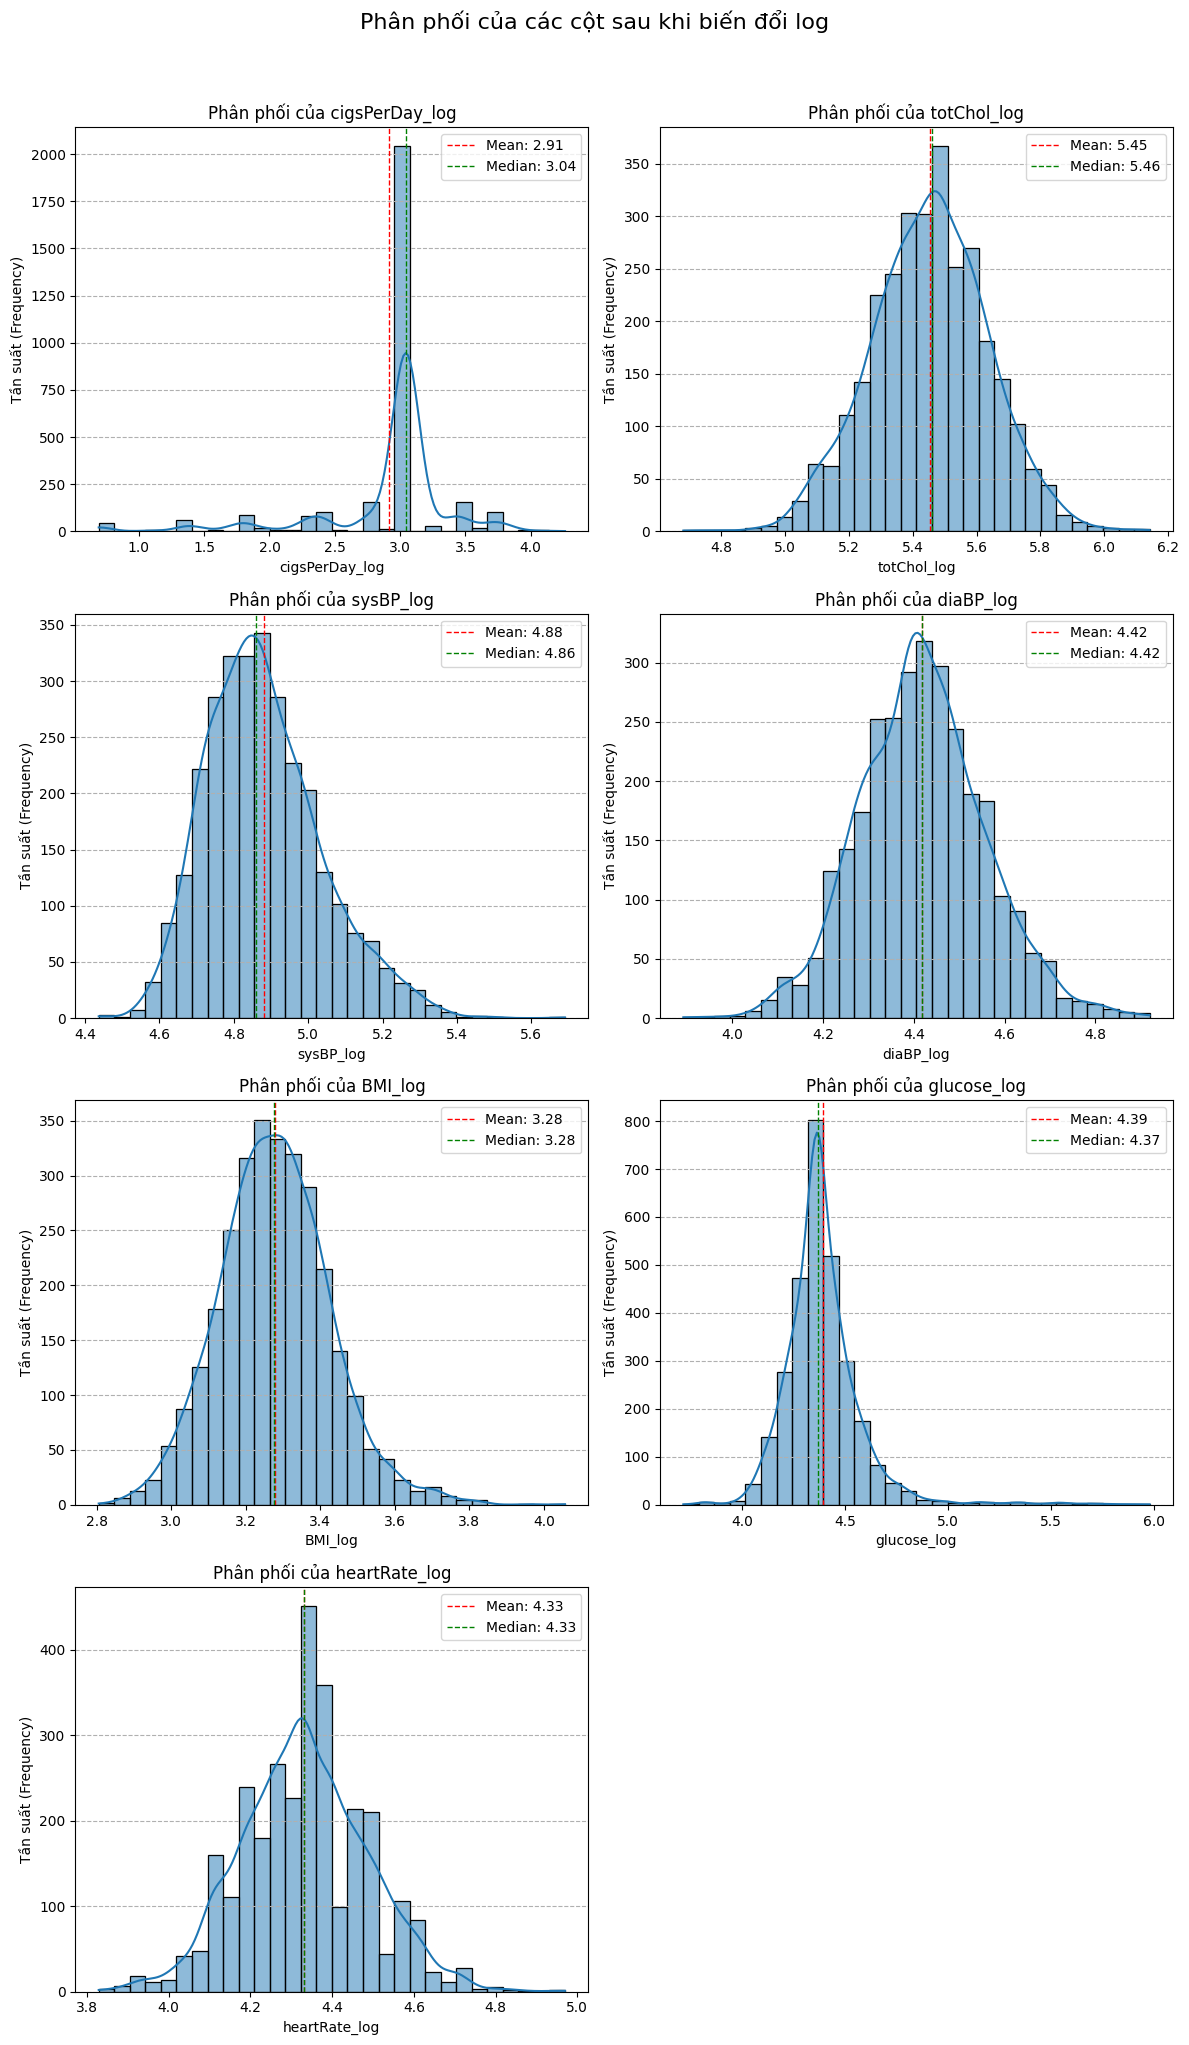

In [296]:
# Các cột có chứa null mà bạn muốn xem phân phối
cols_to_plot_dist = ['cigsPerDay_log', 'totChol_log', 'sysBP_log', 'diaBP_log', 'BMI_log', 'glucose_log', 'heartRate_log']

# Lọc ra các cột thực sự tồn tại trong X_train
cols_to_plot_dist = [col for col in cols_to_plot_dist if col in X_train.columns]

# Tính số hàng và cột cho lưới subplot
n_cols = len(cols_to_plot_dist)
n_rows = (n_cols + 1) // 2 # Sắp xếp thành 2 cột

plt.figure(figsize=(12, 5 * n_rows))
plt.suptitle('Phân phối của các cột sau khi biến đổi log', fontsize=16, y=1.02)

for i, col in enumerate(cols_to_plot_dist):
    plt.subplot(n_rows, 2, i + 1)

    # Lấy dữ liệu không phải null của cột hiện tại từ X_train
    data_to_plot = X_train[col].dropna()

    # Vẽ histogram bằng seaborn (có thể thêm kde=True để vẽ đường ước lượng mật độ)
    sns.histplot(data_to_plot, kde=True, bins=30) # bins=30 là số lượng cột trong histogram

    # Tính toán và hiển thị mean, median (nếu là cột số)
    if pd.api.types.is_numeric_dtype(data_to_plot):
        mean_val = data_to_plot.mean()
        median_val = data_to_plot.median()
        plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
        plt.legend()

    plt.title(f'Phân phối của {col}')
    plt.xlabel(col)
    plt.ylabel('Tần suất (Frequency)')
    plt.grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 1]) # Điều chỉnh layout để không bị chồng chéo
plt.show()

--> Có cải thiện 

#### Tạm thời, tôi sẽ không tiếp tục feature engineering nữa để tiện cho việc so sánh khi mô hình trước khi feature và sau khi feature

## Cấu hình grid_search_cv

In [297]:
param_distributions = [
    {
        'penalty': ['l1', 'l2'],
        'C': loguniform(0.01, 100),
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['l2'],
        'C': loguniform(0.01, 100),
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': [None],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['elasticnet'],
        'C': loguniform(0.01, 100),
        'solver': ['saga'],
        'l1_ratio': uniform(0, 1),
        'class_weight': [None, 'balanced']
    }
]

In [298]:
# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp trong mỗi fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [299]:
# --- 3. Thiết lập GridSearchCV ---
# Tăng max_iter để tránh lỗi hội tụ, đặc biệt với solver 'saga' hoặc C nhỏ
logistic_model = LogisticRegression(random_state=42, max_iter=5000)

n_iterations = 50 # Số lượng kết hợp tham số ngẫu nhiên cần thử (điều chỉnh nếu cần)

random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=n_iterations, # Tham số quan trọng của RandomizedSearchCV
    cv=cv_strategy,
    scoring='recall',    # Giữ nguyên chỉ số đánh giá
    n_jobs=-1,           # Sử dụng tất cả CPU cores
    verbose=1,           # Hiển thị tiến trình
    random_state=42      # Để tái lập kết quả
)

## Train model trước khi dùng log và standardscaler

In [ ]:

# --- 4. Huấn luyện ---
print("Starting RandomSearchCV...")
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
print("RandomSearchCV finished.")

# Tính toán thời gian huấn luyện
train_time = end_time - start_time
print(f"Thời gian huấn luyện: {train_time:.2f} giây")

#### Nguyên nhân phổ biến của ConvergenceWarning (Nếu có)

1.  **`max_iter` quá thấp:** Giá trị `max_iter` (số lần lặp tối đa) được đặt cho `LogisticRegression` (hoặc giá trị mặc định của nó) không đủ lớn để thuật toán tối ưu tìm được điểm hội tụ. Điều này đặc biệt có thể xảy ra với một số bộ dữ liệu phức tạp hoặc khi sử dụng một số `solver` nhất định (ví dụ: `saga` đôi khi cần nhiều lần lặp hơn).

2.  **Dữ liệu chưa được chuẩn hóa (Scaling):** Đây là một nguyên nhân **rất phổ biến** đối với các mô hình tuyến tính như Logistic Regression. Khi các đặc trưng đầu vào có thang đo (scale) rất khác nhau (ví dụ: tuổi từ 30-70 trong khi cholesterol từ 100-600), thuật toán tối ưu có thể gặp khó khăn trong việc tìm hướng đi hiệu quả và cần nhiều lần lặp hơn để hội tụ. Việc thiếu scaling thường là nguyên nhân chính khi gặp cảnh báo này trên dữ liệu thô.

3.  **Tham số Regularization `C` rất nhỏ:** Tham số `C` trong Logistic Regression là nghịch đảo của cường độ regularization (alpha). Khi `C` rất nhỏ (ví dụ: 0.01, 0.001), điều này tương đương với việc áp dụng regularization rất mạnh (L1 hoặc L2). Regularization mạnh có thể làm cho bề mặt hàm mục tiêu trở nên khó tối ưu hơn, đôi khi đòi hỏi nhiều lần lặp hơn để tìm được điểm hội tụ.

4.  **Lựa chọn `solver`:** Các `solver` khác nhau (ví dụ: `liblinear`, `lbfgs`, `sag`, `saga`, `newton-cg`) sử dụng các thuật toán tối ưu khác nhau. Một số solver có thể hội tụ nhanh hơn hoặc ổn định hơn các solver khác trên một bộ dữ liệu cụ thể hoặc với một loại regularization cụ thể. `GridSearchCV` giúp thử nghiệm các solver khác nhau, nhưng một số kết hợp có thể gặp khó khăn về hội tụ.

In [ ]:
# --- 5. Xem Kết quả ---
print("\nBest Parameters found:")
print(random_search.best_params_)

In [ ]:
print(f"\nBest recall score on Cross-Validation:")
print(random_search.best_score_)

In [ ]:
# Khi đoán mò, tỷ lệ đoán trúng người bị bệnh tim là:
print("Tỷ lệ đoán trúng khi ta đoán mò:",len(df[df["TenYearCHD"]==1])/len(df))

Ý nghĩa con số:
+ Chúng ta dự đoán đúng khoảng 7/10 số người trong 10 năm tới sẽ mắc bệnh tim, tuy nhiên 3/10 số người ta bỏ sót (dự đoán sai). Điều này thực tế rất nguy hiểm đối với những TH là y tế như này.
+ So sánh với TH "đoán mò" (15%) thì thực tế con số 66% cao hơn nhiều, tuy vậy thì việc ta dừng ở con số 70% này là thực sự không tốt

In [ ]:
# --- 6. Đánh giá mô hình tốt nhất trên tập Test ---
print("\nEvaluating the best model found on the test set:")
best_model = random_search.best_estimator_
# Dự đoán trên X_test đã tiền xử lý
y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

try:
    roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")
except ValueError:
    print("ROC AUC score cannot be calculated.")

#### Nhận xét Kết quả Mô hình Logistic Regression (Sau FE & Khắc phục Leakage)

Kết quả đánh giá trên tập kiểm tra cho thấy:

*   **Recall (Lớp 1 - Mắc bệnh): 0.61** - Mô hình xác định được 61% ca bệnh thực sự, tuy nhiên vẫn bỏ sót gần 40%, có thể chưa đủ cao cho ứng dụng y tế.
*   **Precision (Lớp 1 - Mắc bệnh): 0.25** - Rất thấp, chỉ 25% các trường hợp dự đoán mắc bệnh là đúng, mô hình tạo ra nhiều cảnh báo sai (False Positives).
*   **F1-Score (Lớp 1 - Mắc bệnh): 0.35** - Thấp, phản ánh sự mất cân bằng giữa Precision và Recall.
*   **Accuracy: 0.66** - Độ chính xác tổng thể ở mức khá, nhưng bị ảnh hưởng bởi việc dự đoán đúng lớp đa số (không mắc bệnh).
*   **ROC AUC Score: 0.7023** - Cho thấy khả năng phân biệt giữa hai lớp ở mức khá, tốt hơn ngẫu nhiên nhưng chưa xuất sắc và thấp hơn một chút so với các phiên bản bị leakage.

**Kết luận:** Việc khắc phục data leakage cho thấy hiệu suất thực tế của mô hình. Mặc dù tối ưu theo recall, kết quả vẫn chưa đạt kỳ vọng và precision rất thấp. Các bước feature engineering hiện tại (log transform, scaling) chưa đủ để cải thiện đáng kể hiệu suất dự đoán của Logistic Regression cho bài toán này. Cần xem xét các kỹ thuật khác (RobustScaler, tạo feature mới, resampling) hoặc thử nghiệm các mô hình phức tạp hơn.

#### Ta xem xét cải thiện bằng việc thử scoring theo "f1"

In [305]:
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=n_iterations, # Tham số quan trọng của RandomizedSearchCV
    cv=cv_strategy,
    scoring='f1',    # Thay đổi chỉ số đánh giá
    n_jobs=-1,           # Sử dụng tất cả CPU cores
    verbose=1,           # Hiển thị tiến trình
    random_state=42      # Để tái lập kết quả
)

In [306]:

# # --- 4. Huấn luyện ---
# print("Starting RandomSearchCV...")
# start_time = time.time()
# random_search.fit(X_train, y_train)
# end_time = time.time()
# print("RandomSearchCV finished.")

# # Tính toán thời gian huấn luyện
# train_time = end_time - start_time
# print(f"Thời gian huấn luyện: {train_time:.2f} giây")

--> Không hội tụ, ta thôi (nếu muốn các bạn có thể làm tiếp nhaa)

## Train model sau khi Feature Engineering

### 1. Tiếp tục feature engineering

In [307]:
# Đầu tiên, ta loại bỏ các cột không phải là log trước đã
feature_columns = [
    'male',
    'age',
    'currentSmoker',
    'BPMeds',
    'prevalentStroke',
    'prevalentHyp',
    'diabetes',
    'cigsPerDay_log', 
    'totChol_log',    
    'sysBP_log',     
    'diaBP_log',      
    'BMI_log',        
    'glucose_log',   
    'heartRate_log'  
]


In [308]:
X_train = X_train[feature_columns]
X_test = X_test[feature_columns]

Chuẩn hóa các cột

In [309]:
# Chuẩn hóa X_train, X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2. Train model

In [310]:
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=n_iterations, # Tham số quan trọng của RandomizedSearchCV
    cv=cv_strategy,
    scoring='recall',    # Giữ nguyên chỉ số đánh giá
    n_jobs=-1,           # Sử dụng tất cả CPU cores
    verbose=1,           # Hiển thị tiến trình
    random_state=42      # Để tái lập kết quả
)

In [311]:
# Vẫn sử dụng grid_search ở trên, lần này ta fit vào model này

print("Starting RandomSearchCV...")
# Fit trực tiếp lên X_train đã tiền xử lý
random_search.fit(X_train, y_train)
print("RandomSearchCV finished.")

Starting RandomSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomSearchCV finished.


In [312]:
# --- 5. Xem Kết quả ---
print("\nBest Parameters found:")
print(random_search.best_params_)


Best Parameters found:
{'C': np.float64(0.13296521457299515), 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [313]:
print(f"\nBest recall score on Cross-Validation:")
print(random_search.best_score_)


Best recall score on Cross-Validation:
0.705054945054945


--> Recall có tăng nhưng không đáng kể

In [314]:
# --- 6. Đánh giá mô hình tốt nhất trên tập Test ---
print("\nEvaluating the best model found on the test set:")
best_model = random_search.best_estimator_
# Dự đoán trên X_test đã tiền xử lý
y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

try:
    roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")
except ValueError:
    print("ROC AUC score cannot be calculated.")


Evaluating the best model found on the test set:

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.66      0.77      1079
           1       0.24      0.61      0.35       193

    accuracy                           0.66      1272
   macro avg       0.57      0.64      0.56      1272
weighted avg       0.80      0.66      0.70      1272

ROC AUC Score on Test Set: 0.6990


## KẾT LUẬN:
1. Mô hình sau khi feature có sự giảm nhẹ !
2. Mặc dù ta đã train model khá tốt. Song, vẫn không có sự cải thiện chứng tỏ rằng đây là mô hình không phù hợp cho việc dự đoán với tập dữ liệu này. Nên ta sẽ xem xét các model khác (Cái này bạn tự làm nhé !)